In [5]:
import scapy.all as scapy
import matplotlib.pyplot as plt
from collections import Counter
import graphviz
import os

In [3]:
tapo_p100_idle_8_h = scapy.rdpcap('./pcap/idle_8_h.pcapng')
tapo_p100_active = scapy.rdpcap('./pcap/SmartPlug-active.pcapng')
tapo_p100_control = scapy.rdpcap('./pcap/SmartPlug-Control.pcapng')
tapo_p100_idle = scapy.rdpcap('./pcap/SmartPlug-idle.pcapng')
tapo_p100_all = scapy.rdpcap('./pcap/SmartPlug-ALL.pcapng')

calex_bulb_day = scapy.rdpcap('./pcap/bulb-1-day.pcapng')
calex_active_commands = scapy.rdpcap('./pcap/bulb-active-commands.pcapng')
calex_filtered = scapy.rdpcap('./pcap/bulb-filtered.pcap')
calex_only_idle = scapy.rdpcap('./pcap/bulb-only-idle.pcapng')

In [4]:
def protocols(x):
    yield x.name
    while x.payload:
        x = x.payload
        yield x.name

def highest_level_protocol(packet):
    rename = {'NTPHeader':'NTP', 'DHCP options':'DHCP', 'UDP in ICMP':'ICMP'}
    ps = reversed(list(protocols(packet)))
    for p in ps:
        if p not in ["Raw"]:
            if p in rename:
                return rename[p]
            else:
                return p
    return ps[0]

def plot_data(packets, ips, description, device):
    # Variables to store the data
    sent_packet_times = []
    received_packet_times = []
    sent_packet_sizes = []
    received_packet_sizes = []
    protocol_counts = Counter()

    # Extract time information for packets sent and received by the specific IP address
    for packet in packets:
        if packet.haslayer(scapy.IP):
            ip_layer = packet[scapy.IP]
            if ip_layer.src in ips:
                sent_packet_times.append(packet.time)
                sent_packet_sizes.append(len(packet))
                protocol = highest_level_protocol(packet)
                protocol_counts[protocol] += 1
            elif ip_layer.dst in ips:
                received_packet_times.append(packet.time)
                received_packet_sizes.append(len(packet))
                protocol = highest_level_protocol(packet)
                protocol_counts[protocol] += 1

    # Calculate inter-packet times for sent packets
    sent_inter_packet_times = []
    sent_current_times = []
    received_inter_packet_times = []
    received_current_times = []

    for i in range(1, len(sent_packet_times)):
        inter_packet_time = sent_packet_times[i] - sent_packet_times[i - 1]
        sent_inter_packet_times.append(inter_packet_time)
        sent_current_times.append(sent_packet_times[i])

    for i in range(1, len(received_packet_times)):
        inter_packet_time = received_packet_times[i] - received_packet_times[i - 1]
        received_inter_packet_times.append(inter_packet_time)
        received_current_times.append(received_packet_times[i])

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))

    # Plot for sent packets
    plt.scatter(sent_current_times, sent_inter_packet_times, c='blue', marker='o', label='Time between packets sent')

    # Plot for received packets
    plt.scatter(received_current_times, received_inter_packet_times, c='red', marker='x', label='Time between packets received')

    plt.xlabel('Current Time (s)')
    plt.ylabel('Inter-Packet Time (s)')
    plt.title(f'Scatterplot Inter-Packet Times\n({description} {device})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the histograms
    plt.figure(figsize=(12, 6))

    # Histogram for sent packets
    plt.subplot(1, 2, 1)
    plt.hist(sent_inter_packet_times, bins=30, color='blue', alpha=0.7, label='Time between packets sent')
    plt.xlabel('Inter-Packet Time (s)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Inter-Packet Times for Sent Packets\n({description} {device})')
    plt.legend()
    plt.grid(True)

    # Histogram for received packets
    plt.subplot(1, 2, 2)
    plt.hist(received_inter_packet_times, bins=30, color='red', alpha=0.7, label='Time between packets received')
    plt.xlabel('Inter-Packet Time (s)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Inter-Packet Times for Received Packets\n({description} {device})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot the histograms
    plt.figure(figsize=(12, 6))

    # Histogram for sent packets
    plt.subplot(1, 2, 1)
    plt.hist(sent_packet_sizes, bins=30, color='blue', alpha=0.7, label='Sent Packets Size')
    plt.xlabel('Packet Size (bytes)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Packet Sizes for Sent Packets\n({description} {device})')
    plt.legend()
    plt.grid(True)

    # Histogram for received packets
    plt.subplot(1, 2, 2)
    plt.hist(received_packet_sizes, bins=30, color='red', alpha=0.7, label='Received Packets Size')
    plt.xlabel('Packet Size (bytes)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Inter-Packet Times for Received Packets\n({description} {device})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    protocol_labels = list(protocol_counts.keys())
    protocol_sizes = list(protocol_counts.values())

    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(protocol_sizes, labels=protocol_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Highest Identifiable Protocol Distribution for IP Address \n({description} {device})')
    plt.legend()
    plt.show()


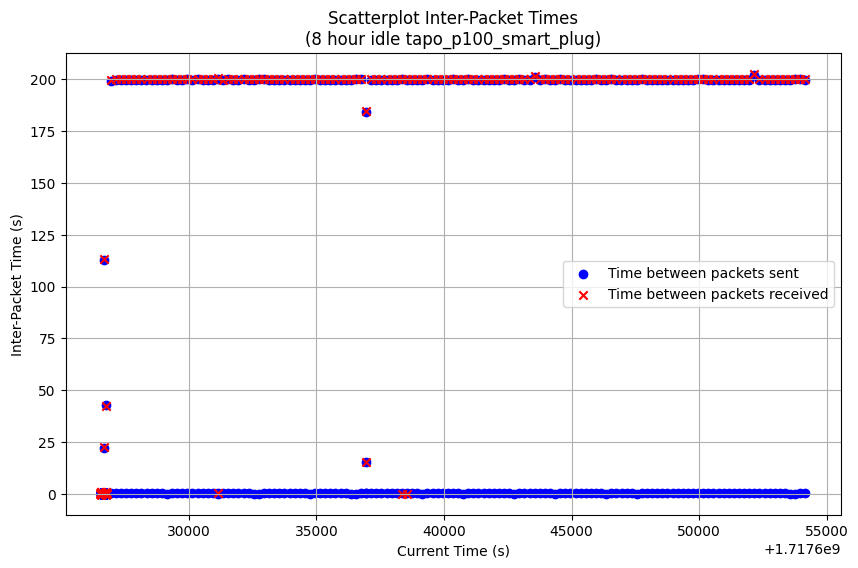

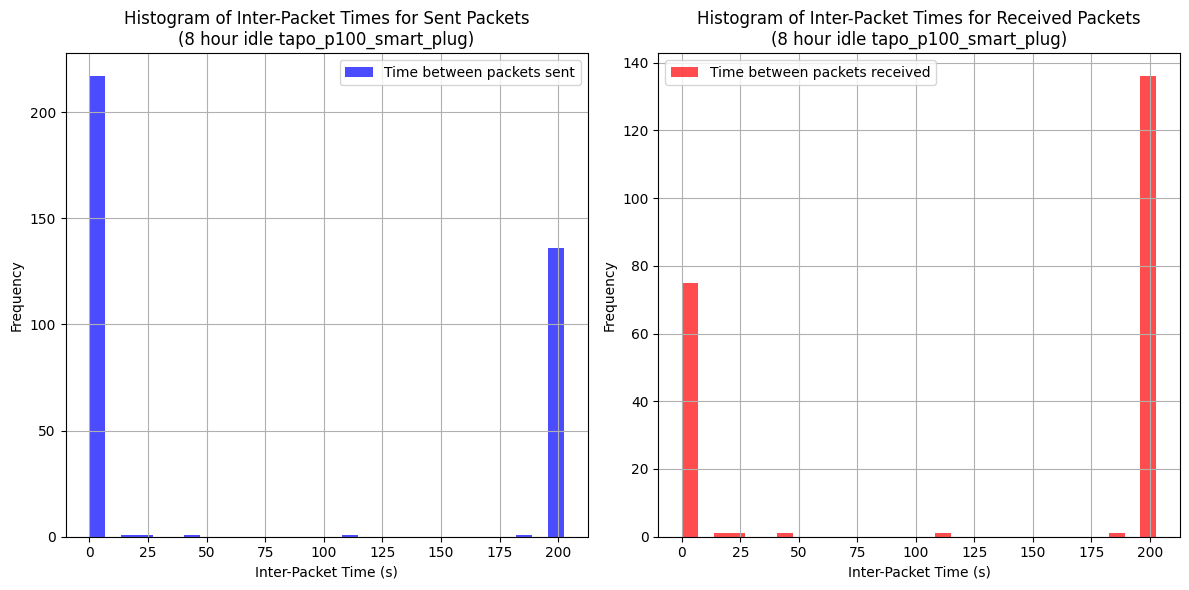

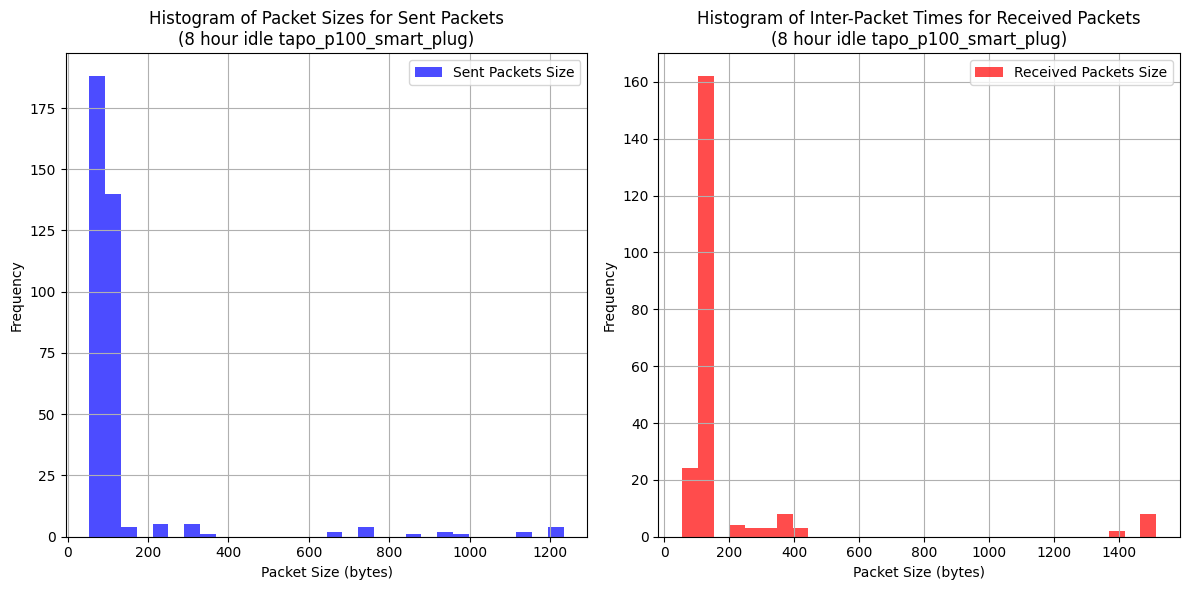

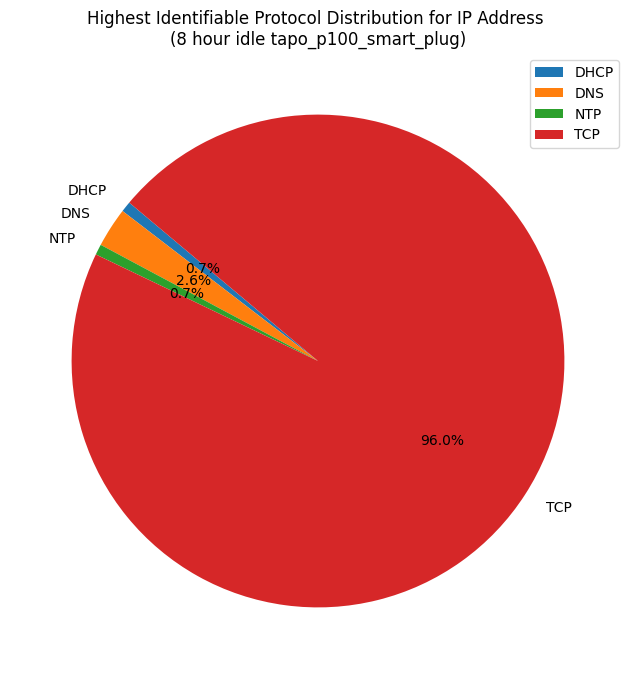

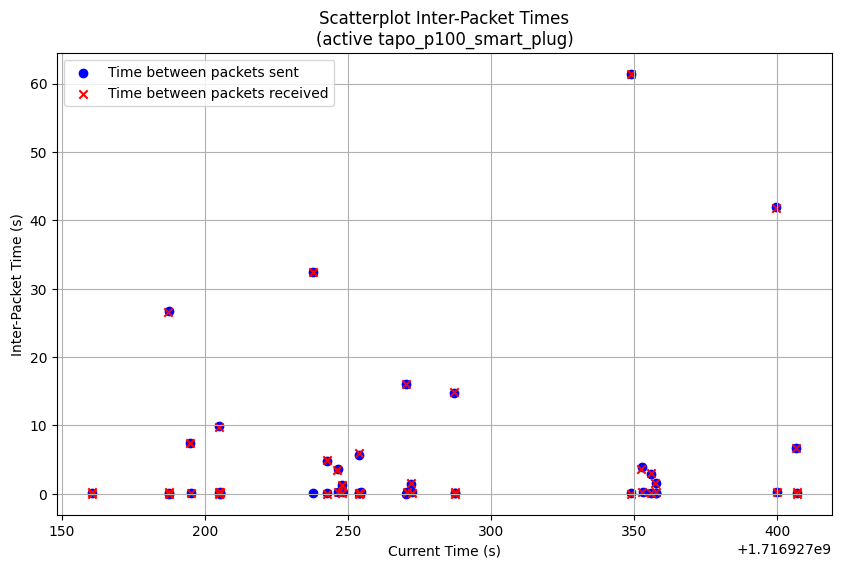

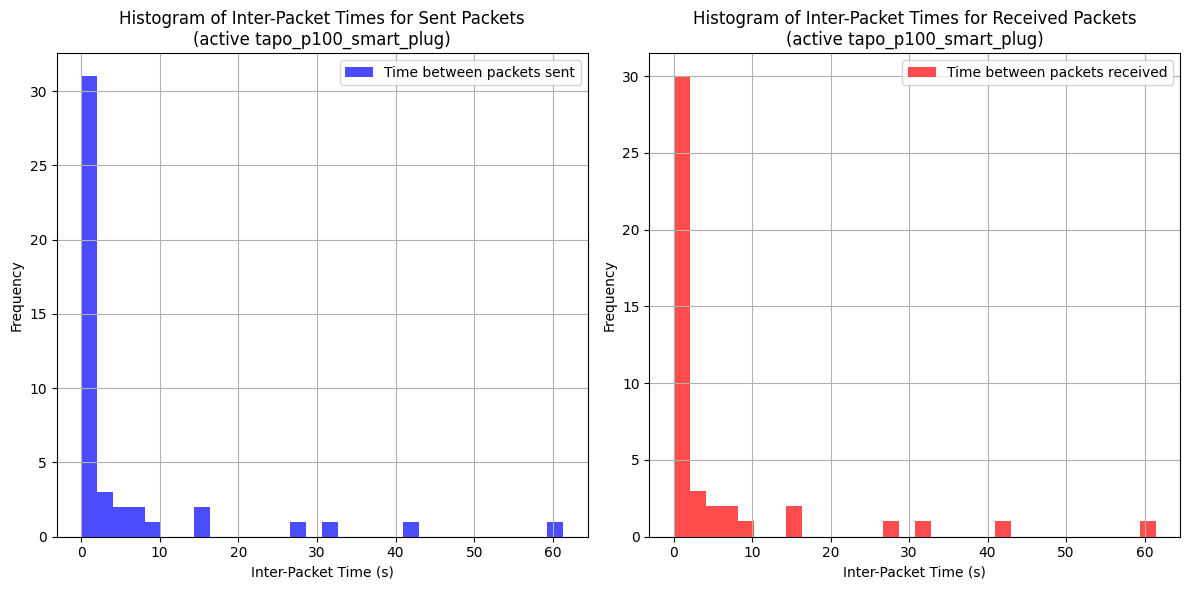

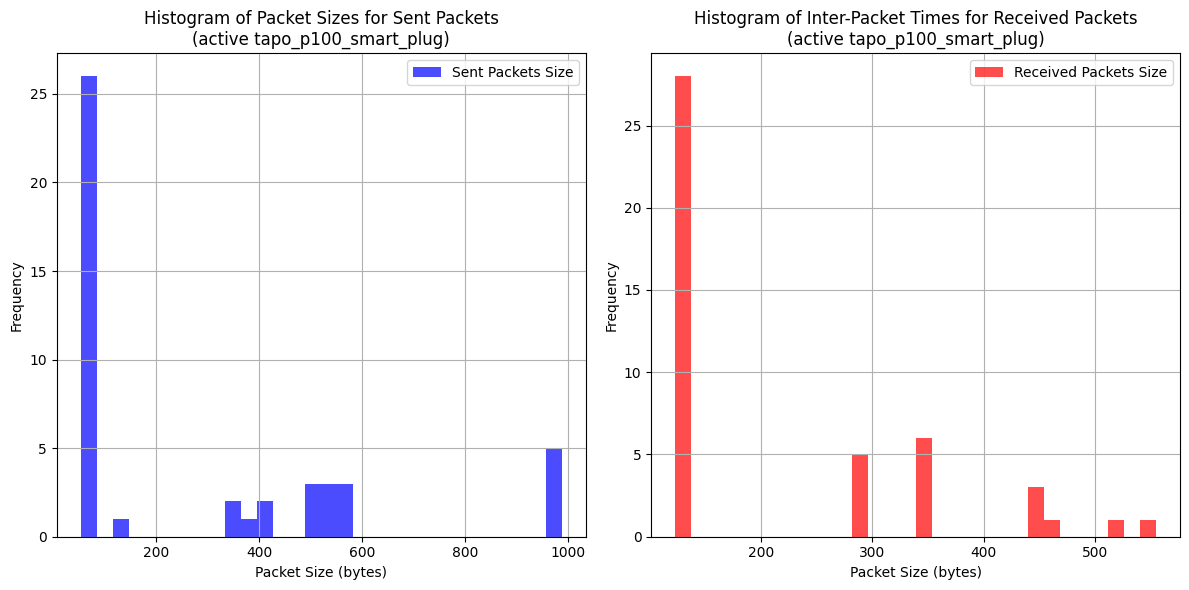

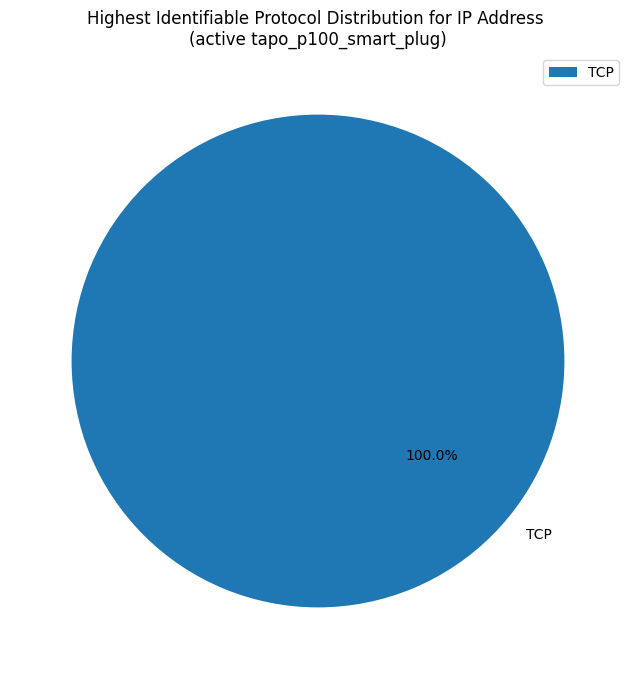

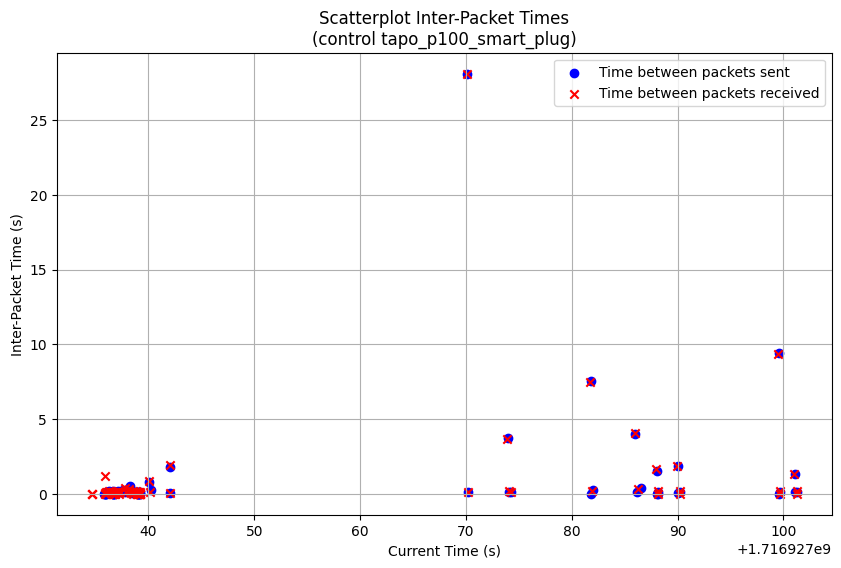

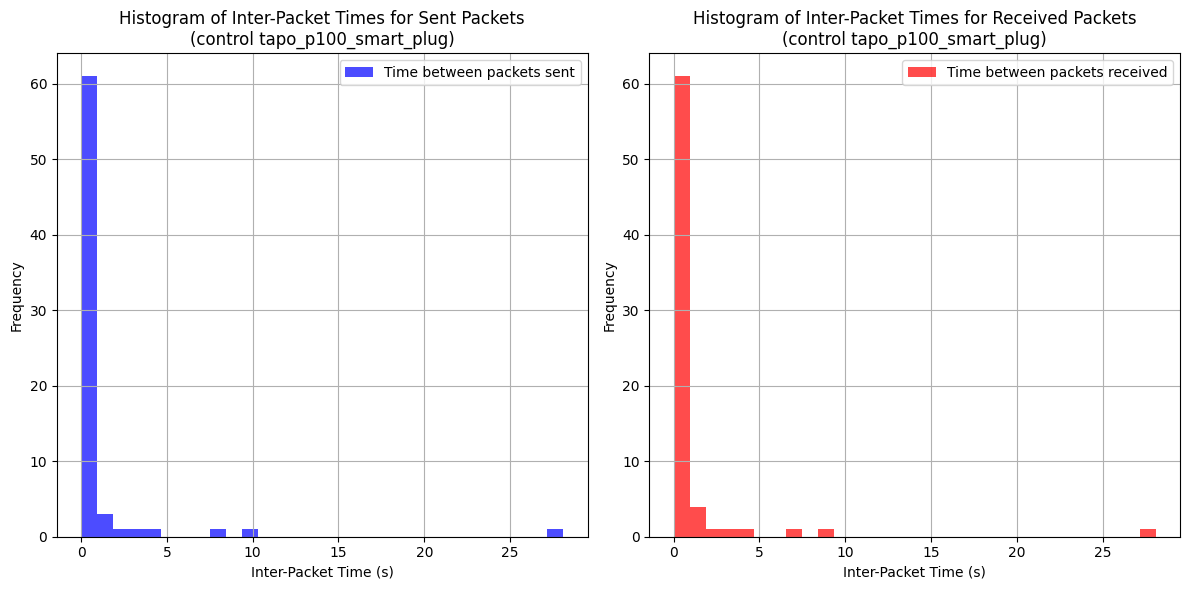

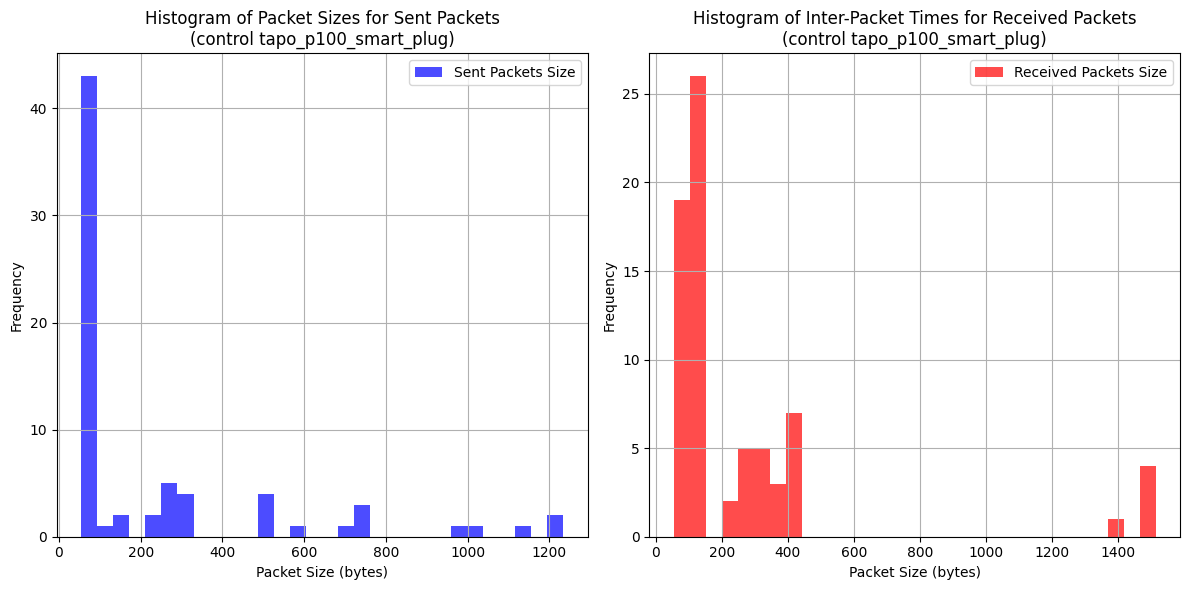

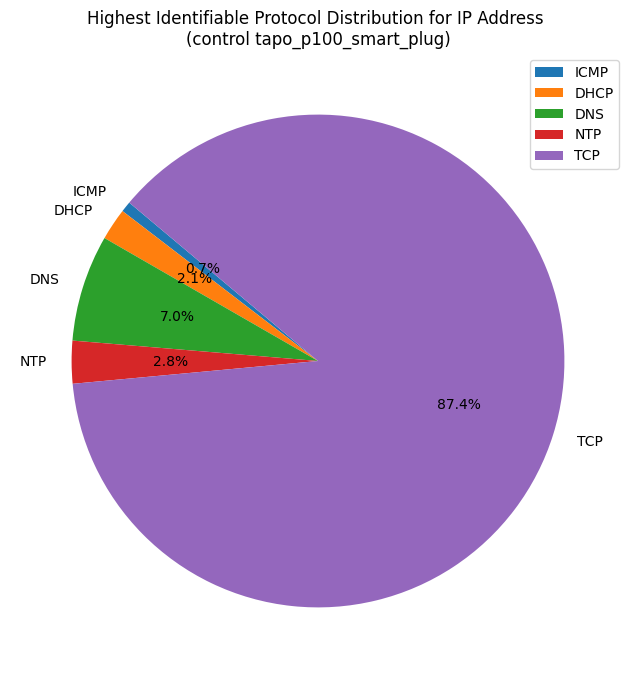

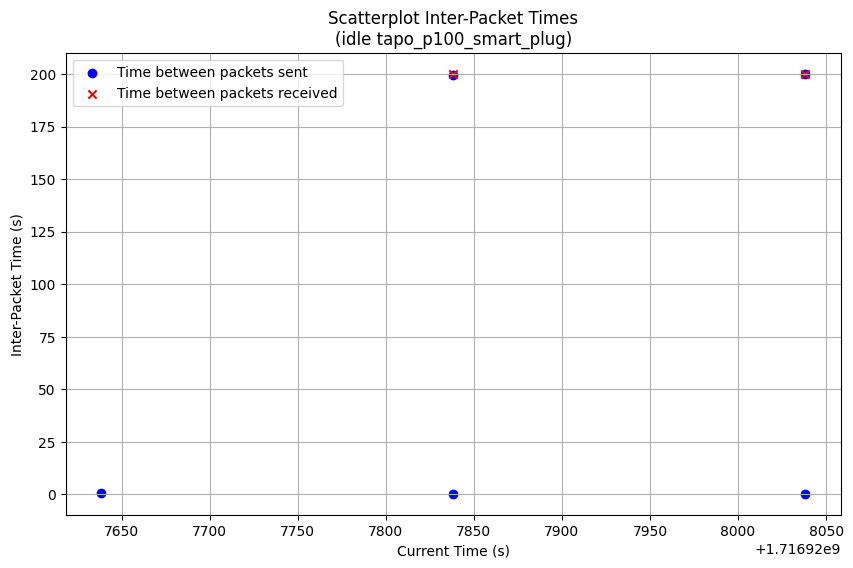

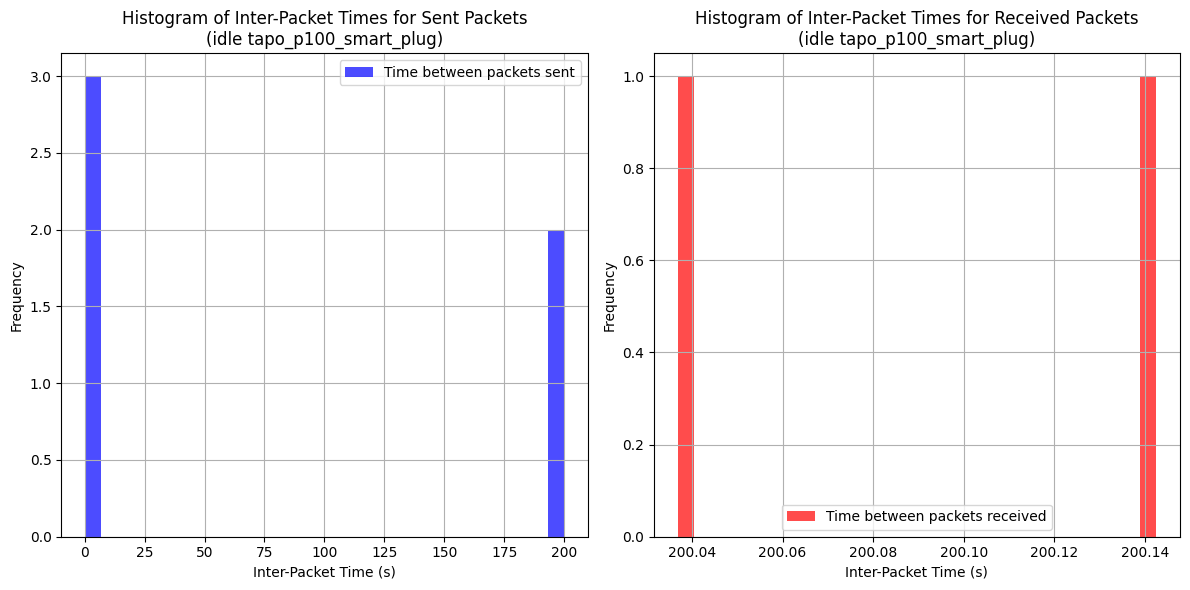

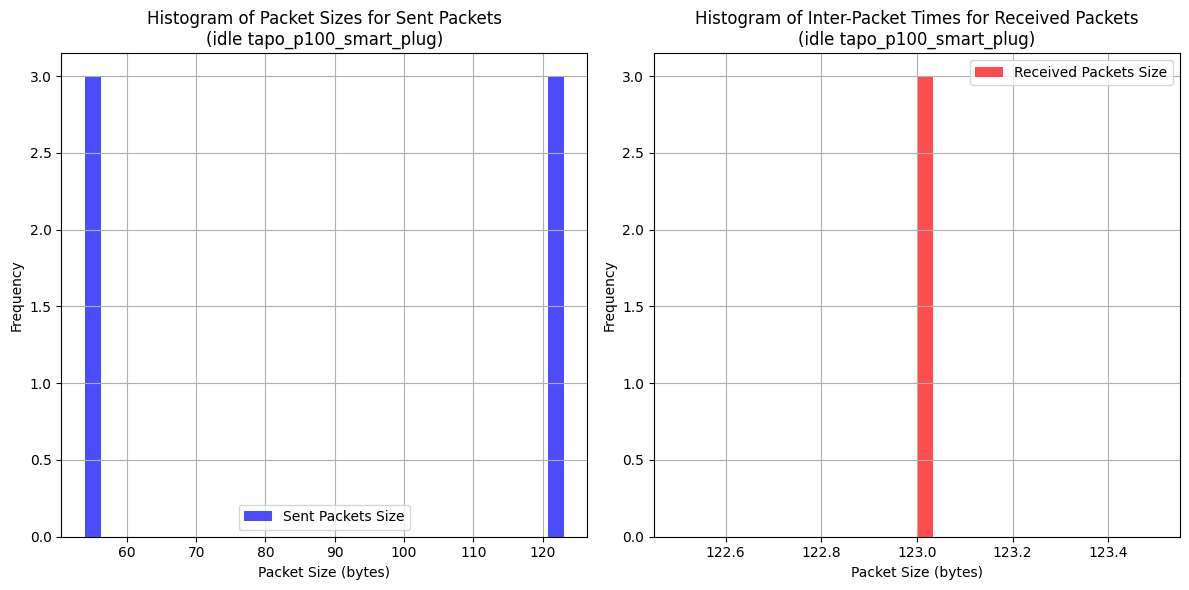

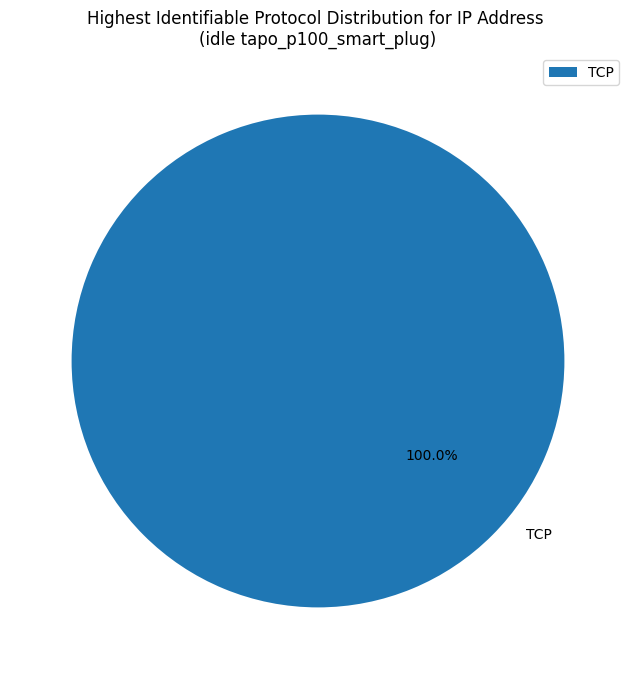

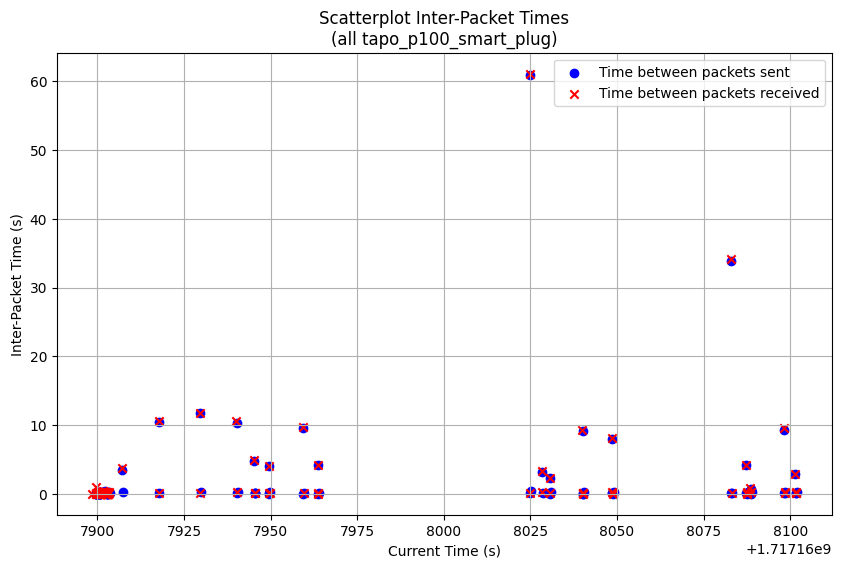

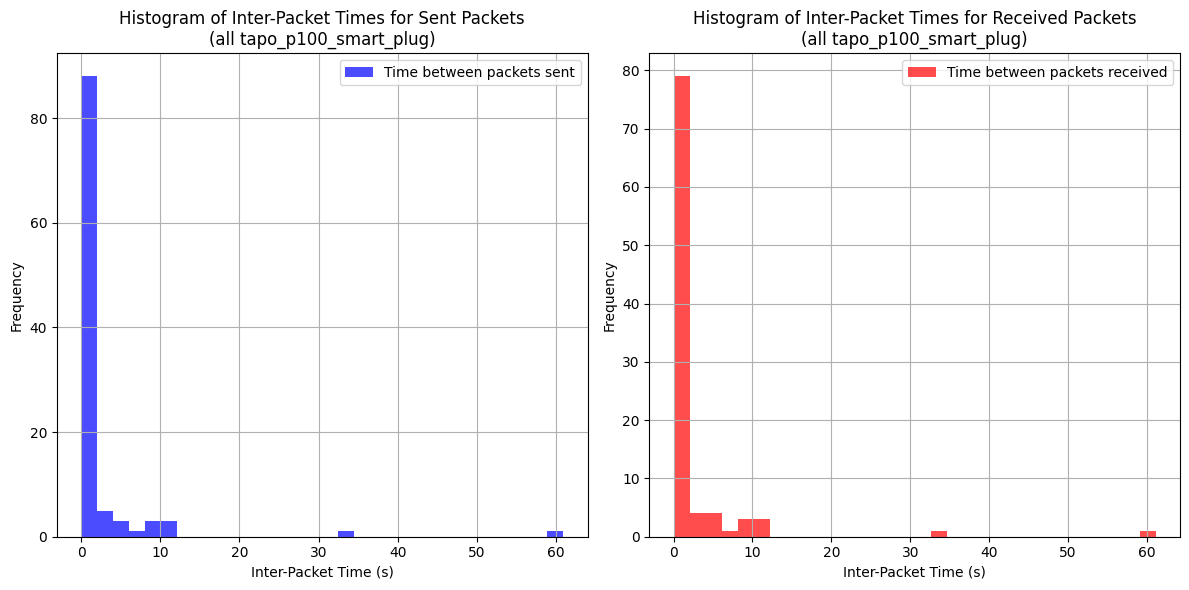

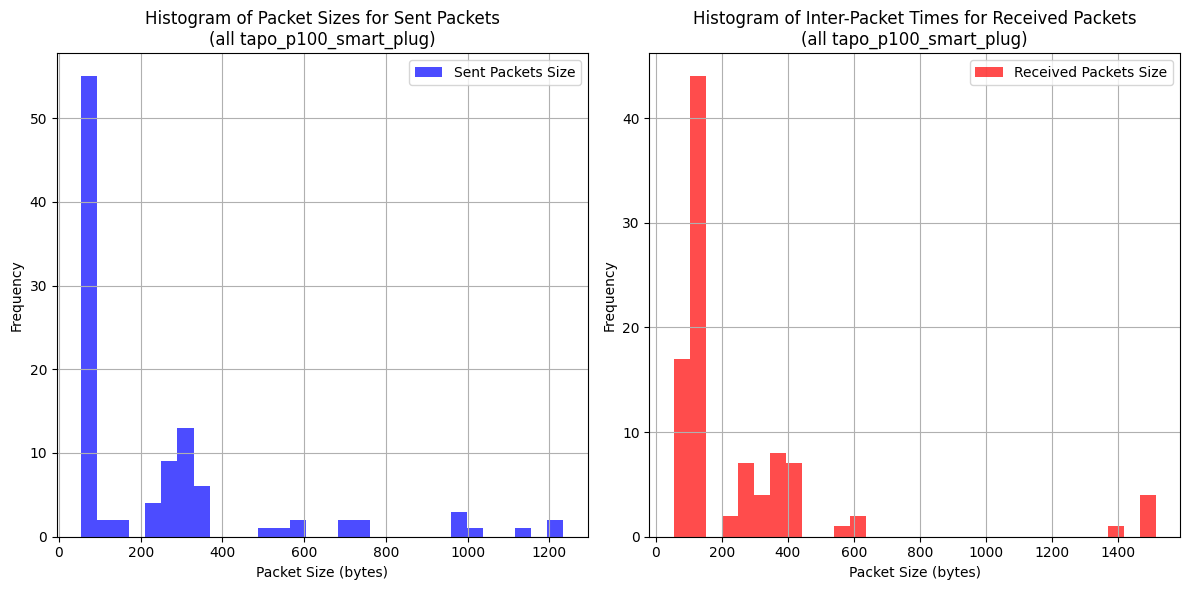

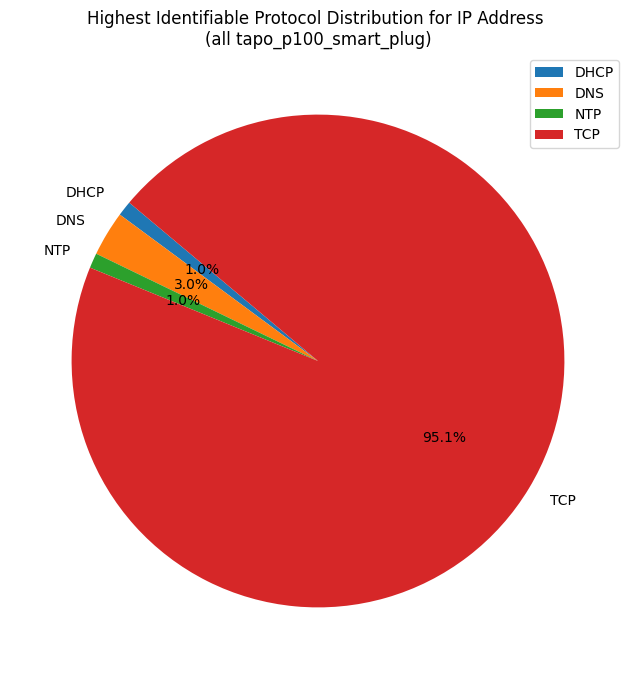

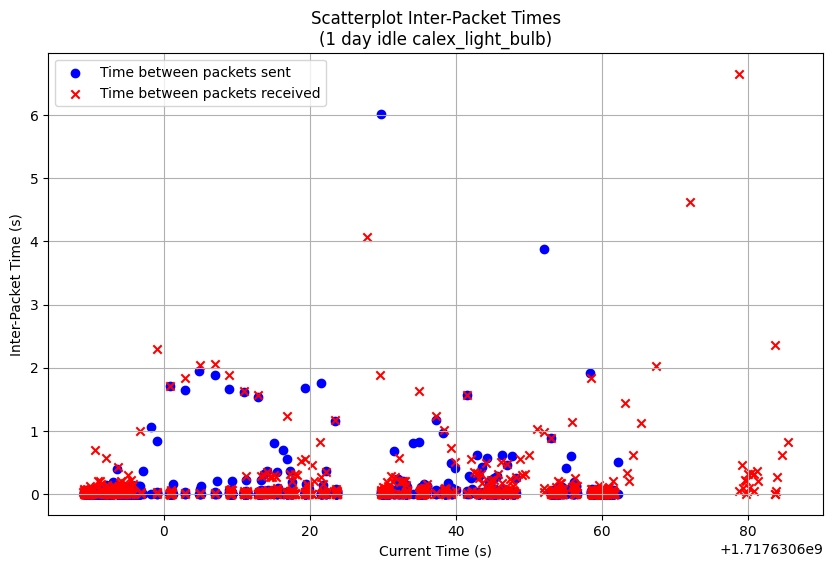

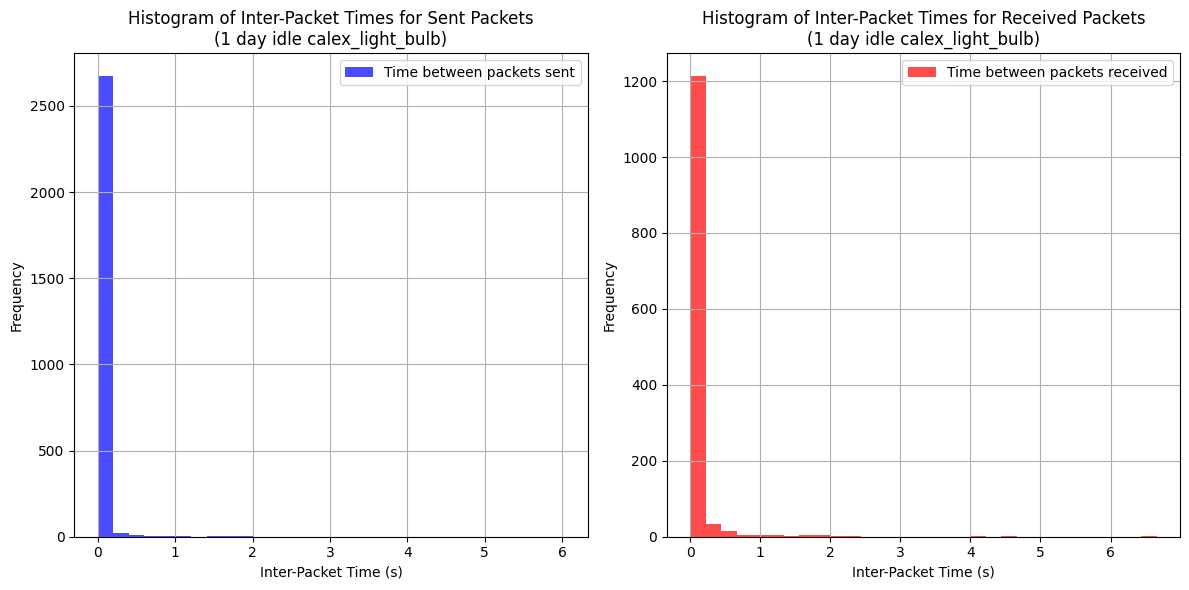

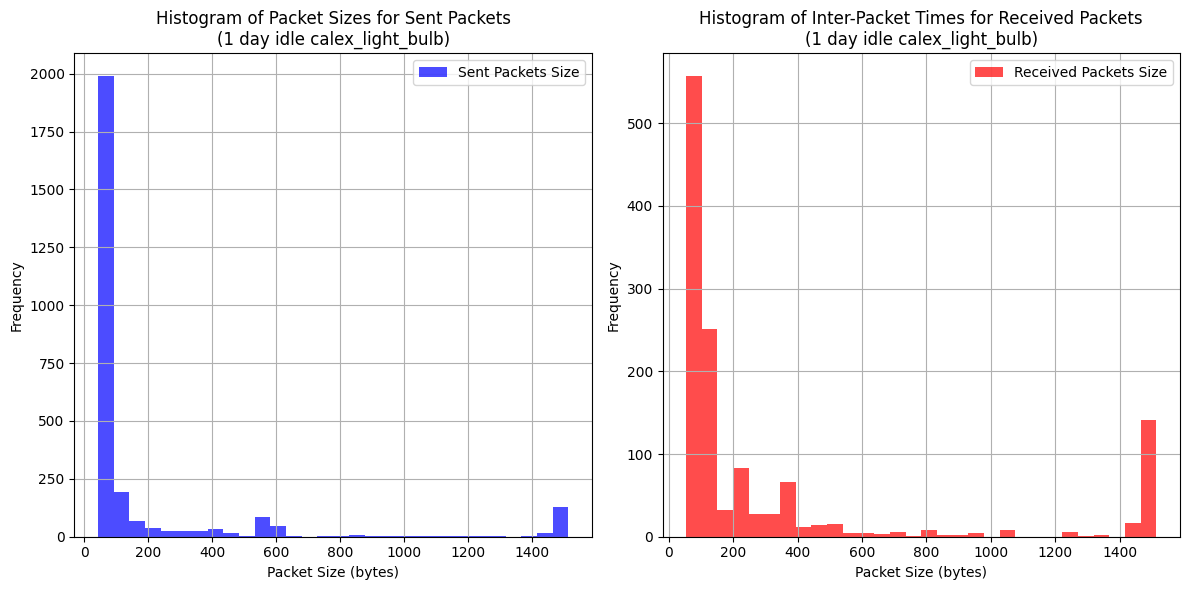

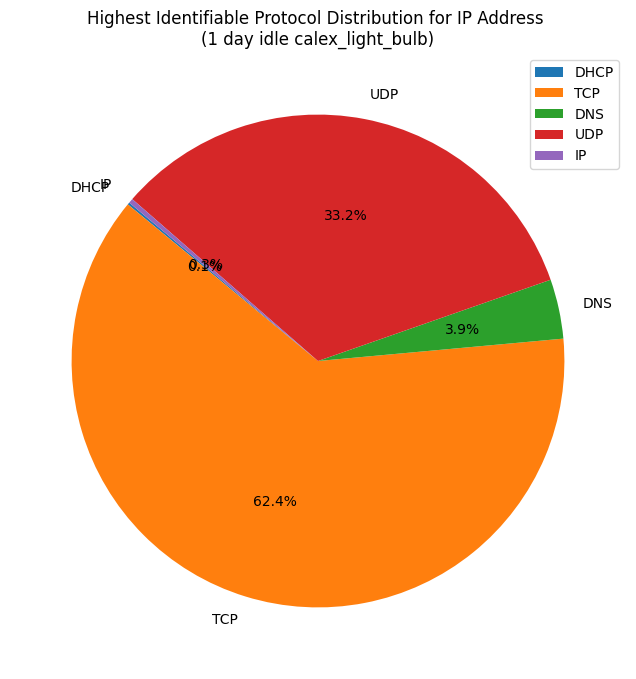

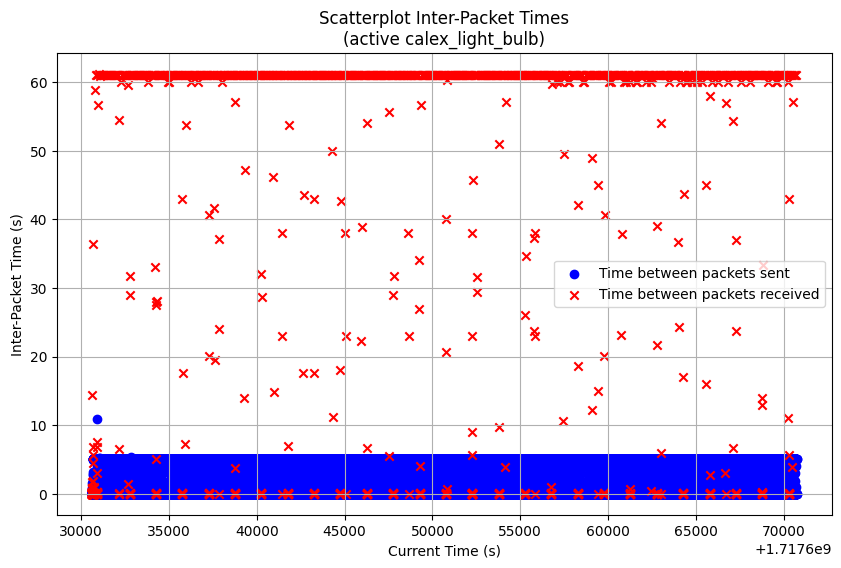

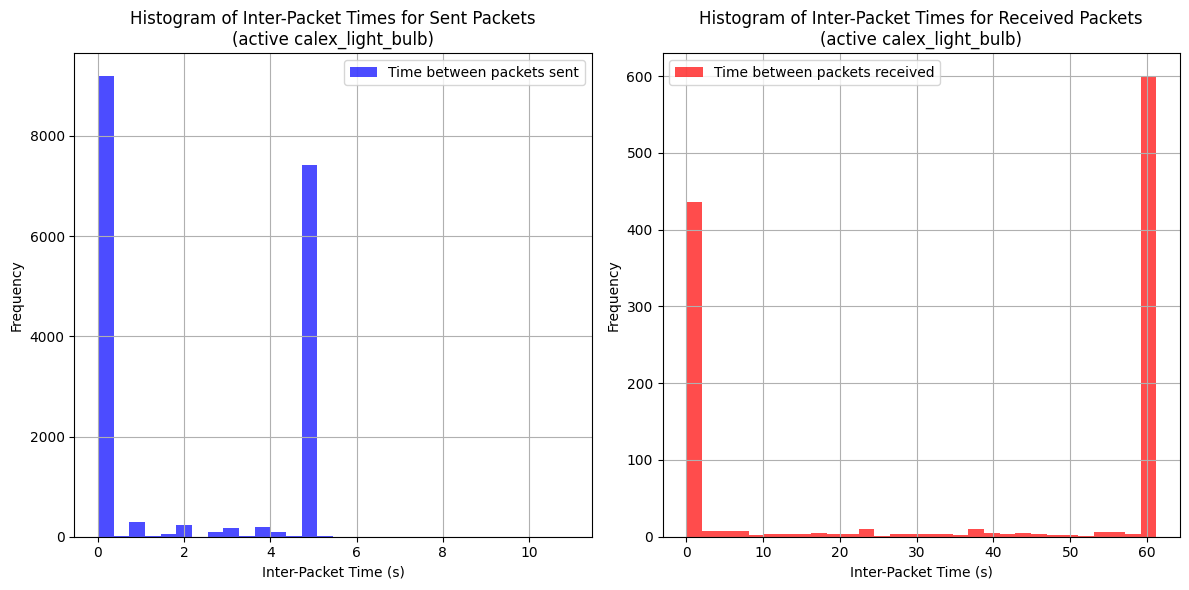

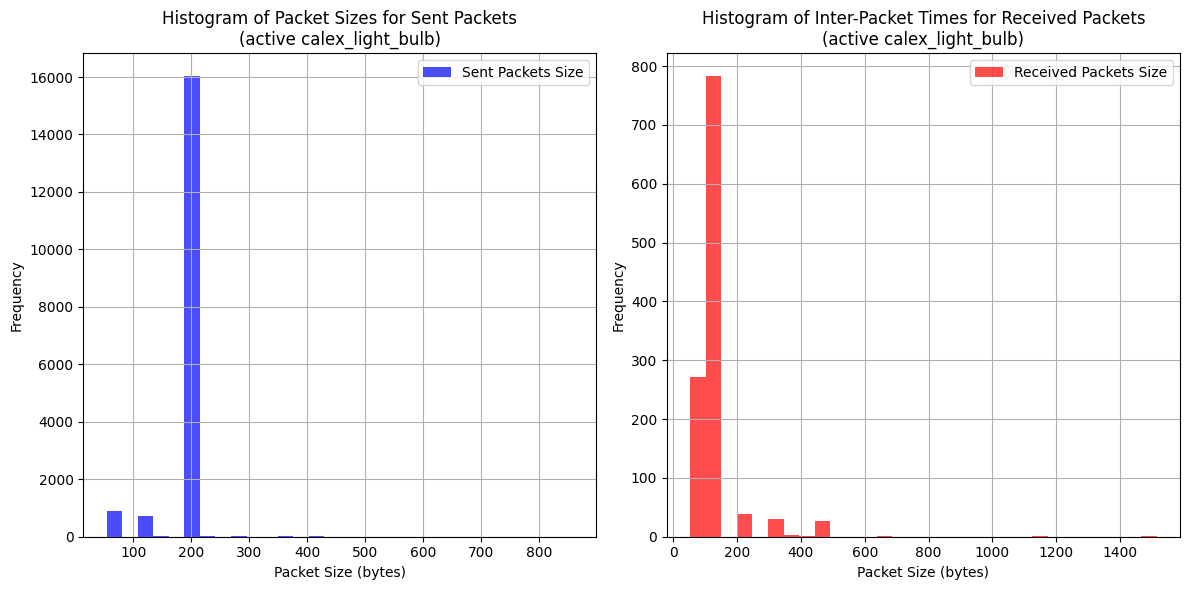

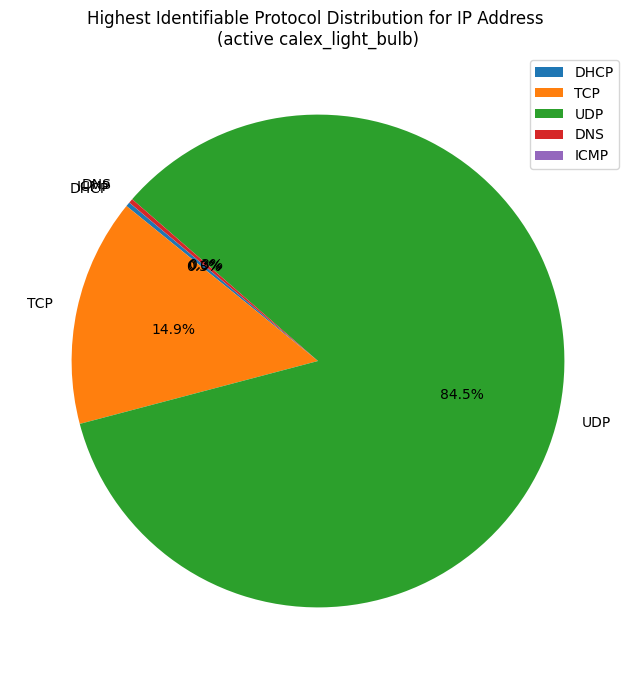

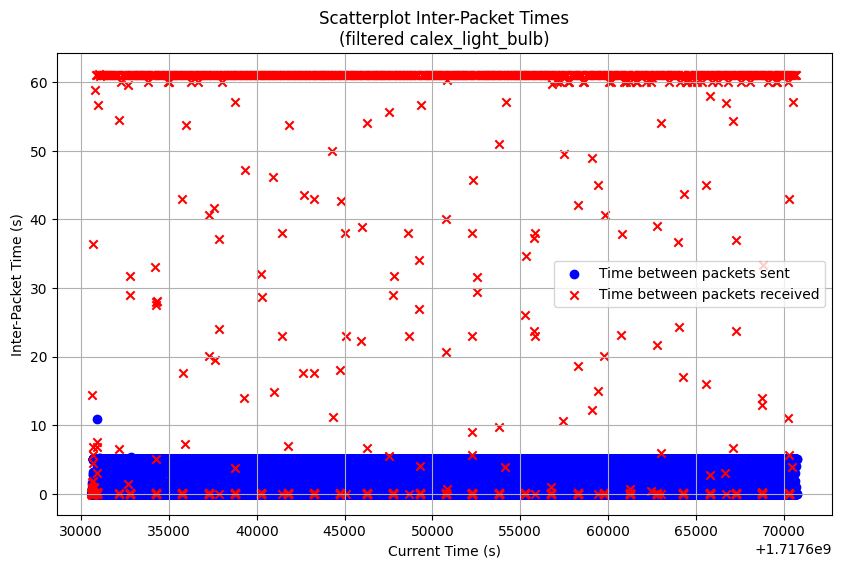

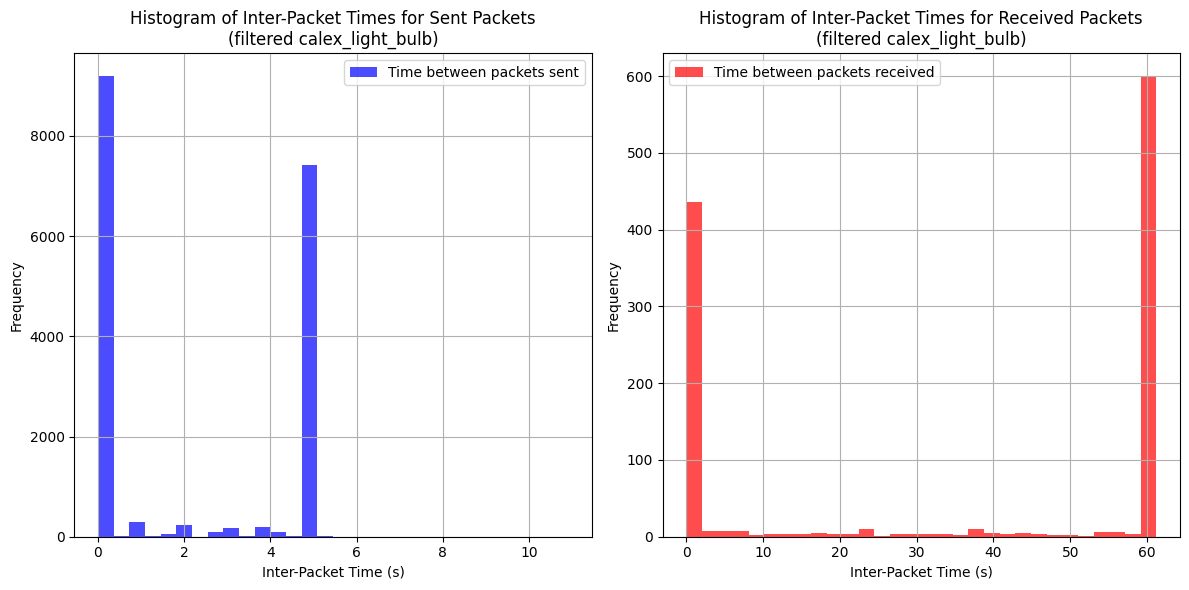

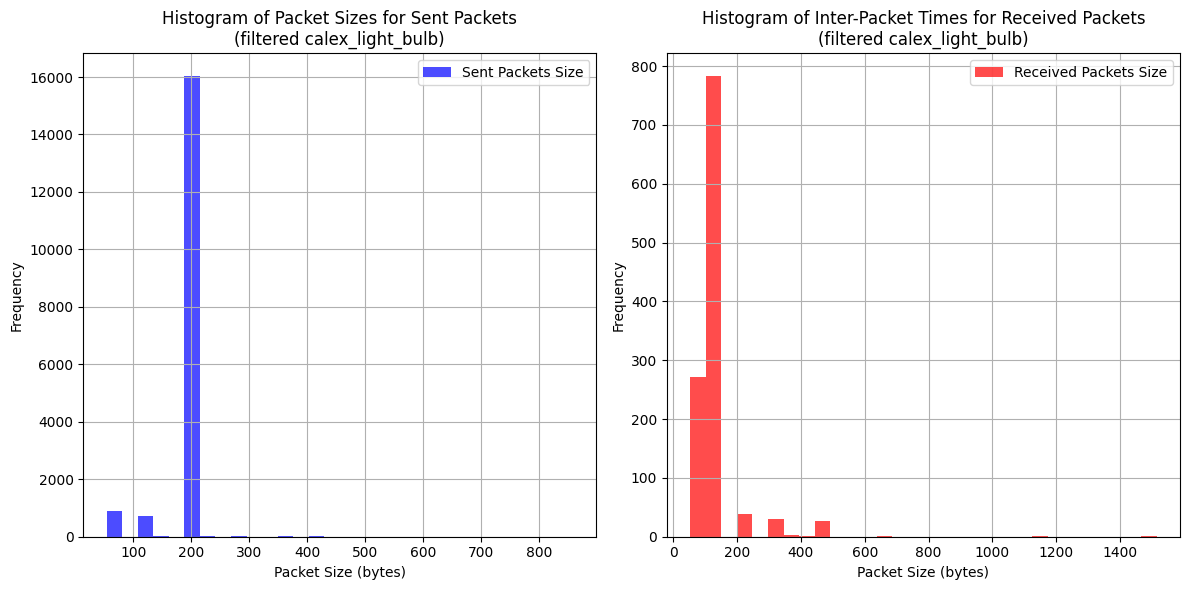

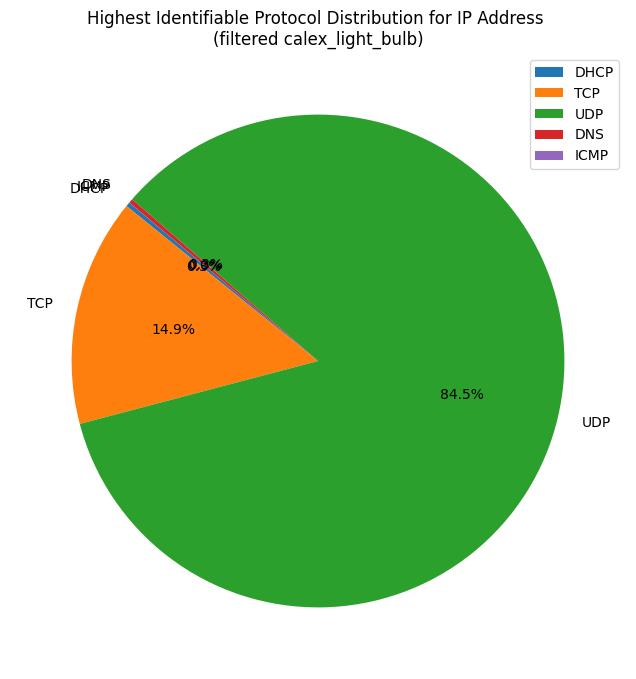

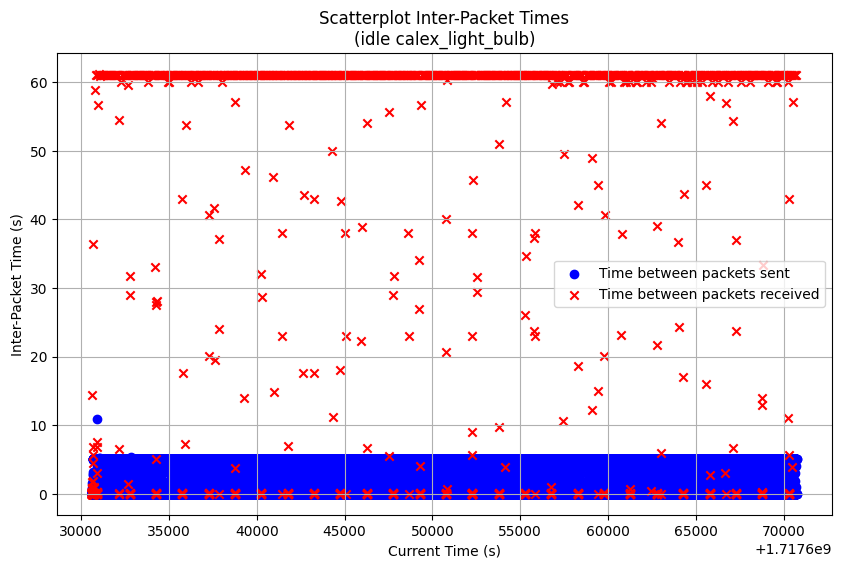

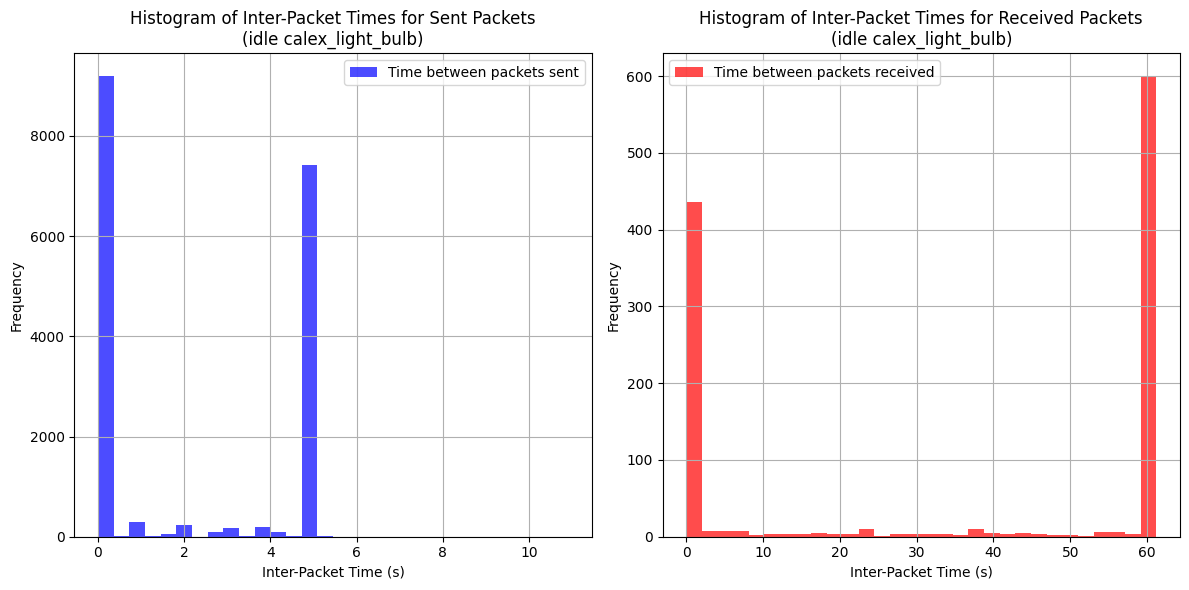

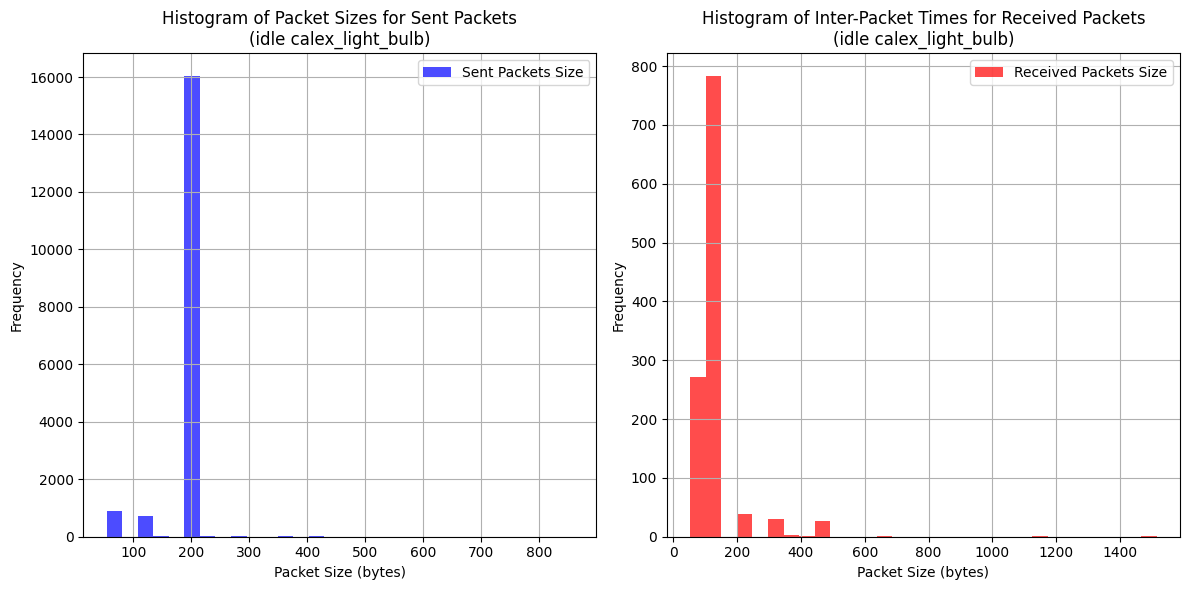

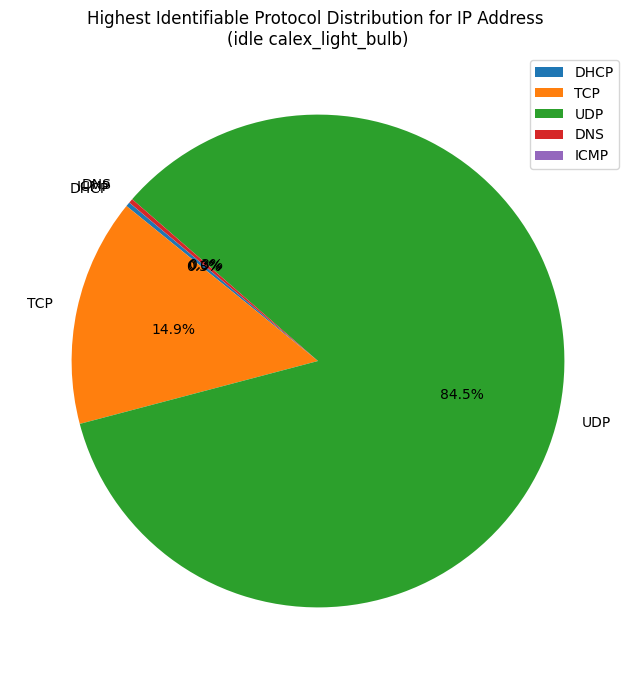

In [88]:
for (packets, ips, description) in [
        (tapo_p100_idle_8_h, ['192.168.137.126', '192.168.137.97'], '8 hour idle'),
        (tapo_p100_active, ['10.42.0.170'], 'active'),
        (tapo_p100_control, ['10.42.0.170'], 'control'),
        (tapo_p100_idle, ['10.42.0.170'], 'idle'),
        (tapo_p100_all, ['10.42.0.170'], 'all'),
        ]:
    plot_data(packets, ips, description, 'tapo_p100_smart_plug')

for (packets, ips, description) in [
        (calex_bulb_day, ['10.42.0.143'], '1 day idle'),
        (calex_active_commands, ['10.42.0.243'], 'active'),
        (calex_filtered, ['10.42.0.243'], 'filtered'),
        (calex_only_idle, ['10.42.0.243'], 'idle'),
        ]:
    plot_data(calex_bulb_day, ips, description, 'calex_light_bulb')

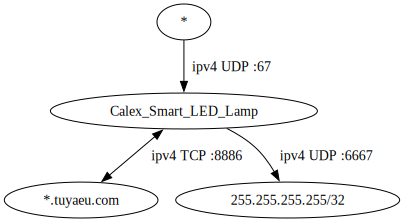

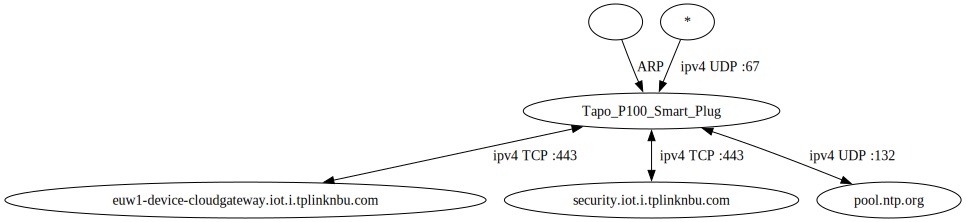

In [8]:
for f in [f for f in os.listdir('./dot') if f.endswith('.dot')]:
    with open(f"./dot/{f}", 'r') as file:
        dot_source = file.read()
        dot = graphviz.Source(dot_source)
        display(dot)